In [86]:
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
import pandas as pd

In [87]:
def polynomial_kernel(xi, xj, degree=2):
    return (xi @ xj.T) ** degree

def gaussian_kernel(xi, xj, c):
    xi = np.atleast_2d(xi)
    xj = np.atleast_2d(xj)

    xi_norm = np.sum(xi**2, axis=-1)
    xj_norm = np.sum(xj**2, axis=-1)

    distance_matrix = xi_norm[:, None] + xj_norm[None, :] - 2 * np.dot(xi, xj.T)

    return np.exp(-c * distance_matrix)

In [ ]:
class KernelPerceptron:
    def __init__(self, 
                 max_iter=30, 
                 min_iter=3, 
                 mode='ovr',
                 kernel_function=polynomial_kernel, 
                 para=2):
        
        self.max_iter = max_iter
        self.min_iter = min_iter
        self.mode = mode.lower()
        self.kernel_function = kernel_function
        self.para = para
        self.weight_matrix = None     
        self.pairwise_weights = dict() 
        self.accuracy_history = []
        self.X_train = None
        self.y_train = None
        self.num_classes = None

    def fit(self, X_data, y_data):
        self.X_train = X_data
        self.y_train = y_data
        self.num_classes = len(np.unique(y_data))

        kernel_matrix = self.kernel_function(X_data, X_data, self.para)

        if self.mode == 'ovr':
            self._fit_ovr(kernel_matrix)
        elif self.mode == 'ovo':
            self._fit_ovo(kernel_matrix)
        else:
            raise ValueError("Mode must be either 'ovr' or 'ovo'.")

        return self

    def _fit_ovr(self, kernel_matrix):
        num_samples = self.X_train.shape[0]
        self.weight_matrix = np.zeros((self.num_classes, num_samples))
        self.accuracy_history = []

        for iteration in range(self.max_iter):
            misclassify = 0
            indices = np.arange(num_samples)
            np.random.shuffle(indices)

            for i in indices:
                predicted_label = np.argmax(self.weight_matrix @ kernel_matrix[i, :])
                if self.y_train[i] != predicted_label:
                    misclassify += 1
                    self.weight_matrix[self.y_train[i], i] += 1
                    self.weight_matrix[predicted_label, i] -= 1

            accuracy_iter = (num_samples - misclassify) / num_samples
            self.accuracy_history.append(accuracy_iter)

            if iteration >= self.min_iter:
                if (self.accuracy_history[-1] - self.accuracy_history[-2]) < 0.01:
                    break

    def _fit_ovo(self, kernel_matrix):
        num_samples = self.X_train.shape[0]
        classes = np.unique(self.y_train)
        for i in range(self.num_classes):
            for j in range(i + 1, self.num_classes):
                self.pairwise_weights[(i, j)] = np.zeros(num_samples)

        self.accuracy_history = []

        for iteration in range(self.max_iter):
            misclassify = 0
            indices = np.arange(num_samples)
            np.random.shuffle(indices)

            for idx in indices:
                true_label = self.y_train[idx]
                for i in range(self.num_classes):
                    for j in range(i+1, self.num_classes):
                        if true_label not in (i, j):
                            continue
                        binary_label = 1 if (true_label == i) else -1
                        prediction_value = self.pairwise_weights[(i, j)] @ kernel_matrix[idx, :]
                        predicted_binary_label = 1 if prediction_value >= 0 else -1
                        if predicted_binary_label != binary_label:
                            misclassify += 1
                            self.pairwise_weights[(i, j)][idx] += binary_label

            y_pred_train = self._predict_full_ovo(kernel_matrix)
            accuracy_iter = np.mean(y_pred_train == self.y_train)
            self.accuracy_history.append(accuracy_iter)

            if iteration >= self.min_iter:
                if (self.accuracy_history[-1] - self.accuracy_history[-2]) < 0.01:
                    break

    def _predict_full_ovo(self, kernel_matrix):
        num_samples = self.X_train.shape[0]
        votes = np.zeros((num_samples, self.num_classes), dtype=int)

        for i in range(self.num_classes):
            for j in range(i + 1, self.num_classes):
                decision_values = self.pairwise_weights[(i, j)] @ kernel_matrix
                for idx in range(num_samples):
                    if decision_values[idx] >= 0:
                        votes[idx, i] += 1
                    else:
                        votes[idx, j] += 1
        y_pred = np.argmax(votes, axis=1)
        return y_pred

    def predict(self, X_data):
        test_kernel_mtx = self.kernel_function(self.X_train, X_data, self.para)

        if self.mode == 'ovr':
            scores = self.weight_matrix @ test_kernel_mtx
            return np.argmax(scores, axis=0)

        elif self.mode == 'ovo':
            num_test = X_data.shape[0]
            votes = np.zeros((num_test, self.num_classes), dtype=int)

            for i in range(self.num_classes):
                for j in range(i + 1, self.num_classes):
                    decision_values = self.pairwise_weights[(i, j)] @ test_kernel_mtx
                    for idx in range(num_test):
                        if decision_values[idx] >= 0:
                            votes[idx, i] += 1
                        else:
                            votes[idx, j] += 1

            return np.argmax(votes, axis=1)
        else:
            raise ValueError("Mode must be either 'ovr' or 'ovo'.")



def split_data_into_train_test(feature_matrix, target_vector, train_ratio=0.8):
    total_samples = feature_matrix.shape[0]
    train_set_size = int(train_ratio * total_samples)
    shuffled_indices = np.random.permutation(total_samples)
    training_indices = shuffled_indices[:train_set_size]
    testing_indices = shuffled_indices[train_set_size:]
    training_features = feature_matrix[training_indices]
    testing_features = feature_matrix[testing_indices]
    training_targets = target_vector[training_indices]
    testing_targets = target_vector[testing_indices]
    return training_features, training_targets, testing_features, testing_targets


def confusion_matrix(X_test, y_test, model):
    y_pred = model.predict(X_test)
    num_classes = len(np.unique(y_test))
    confusion_mtx = np.zeros((num_classes, num_classes))
    for actual, predicted in zip(y_test, y_pred):
        confusion_mtx[actual, predicted] += 1

    row_sums = confusion_mtx.sum(axis=1, keepdims=True)
    confusion_mtx = np.nan_to_num(confusion_mtx / row_sums)

    return confusion_mtx


In [89]:
def load_data(path):
    data = np.loadtxt(path)
    labels = data[:, 0].astype(int)
    features = data[:, 1:]
    # Normalize features
    # features = (features - np.mean(features, axis=0)) / np.std(features, axis=0)
    return features, labels

def visualize_digit(X, y):
    img_indices = [np.argwhere(y == i)[0, 0] for i in range(10)]  
    plt.figure(figsize=(10, 3))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        img_index = img_indices[i]
        plt.imshow(X[img_index, :].reshape(16, 16), cmap='gray') 
        plt.axis('off')
    plt.tight_layout()
    plt.show()

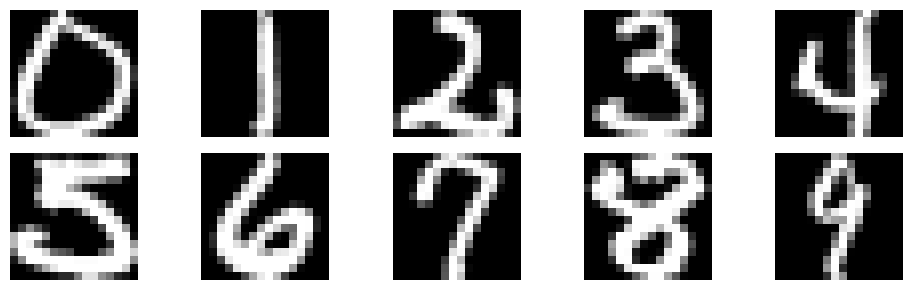

In [90]:
data_path = "data/zipcombo.dat.txt"
X_full, y_full = load_data(data_path)
num_classes = len(np.unique(y_full))
visualize_digit(X_full, y_full)

In [91]:
def basic_results(num_runs, paras, kernel_function=polynomial_kernel, mode='ovr'):

    train_errors_all = np.zeros((len(paras), num_runs))
    test_errors_all  = np.zeros((len(paras), num_runs))

    for run_idx in range(num_runs):
        print(f"[INFO] ---------- Run {run_idx+1}/{num_runs} ----------")
        X_train, y_train, X_test, y_test = split_data_into_train_test(X_full, y_full, train_ratio=0.8)

        for para_idx, para in enumerate(paras):
            print(f"      kernel parameter: {para}")
            model = KernelPerceptron(
                    max_iter=30, 
                    min_iter=3, 
                    mode=mode,
                    kernel_function=kernel_function, 
                    para=para)
            model.fit(X_train, y_train)
            
            y_pred_train = model.predict(X_train)
            train_error  = np.mean(y_pred_train != y_train)

            y_pred_test = model.predict(X_test)
            test_error  = np.mean(y_pred_test != y_test)

            train_errors_all[para_idx, run_idx] = train_error
            test_errors_all[para_idx, run_idx]  = test_error

            print(f"      [para={para}] train_err={train_errors_all[para_idx, run_idx]:.4f}, test_err={test_errors_all[para_idx, run_idx]:.4f}")
        
    return train_errors_all, test_errors_all

In [92]:
def cross_val_error(X_train, y_train, para, kernel_function, mode, n_folds=5, seed=42):
    np.random.seed(seed)
    num_samples = X_train.shape[0]
    indices = np.random.permutation(num_samples)
    fold_sizes = [num_samples // n_folds] * n_folds
    for i in range(num_samples % n_folds):
        fold_sizes[i] += 1

    current_pos = 0
    folds = []
    for fold_size in fold_sizes:
        start, end = current_pos, current_pos + fold_size
        folds.append(indices[start:end])
        current_pos = end

    val_errors = []

    for k_i in range(n_folds):
        val_idx = folds[k_i]
        X_val, y_val = X_train[val_idx], y_train[val_idx]

        train_idx = np.concatenate([folds[j] for j in range(n_folds) if j != k_i])
        X_sub, y_sub = X_train[train_idx], y_train[train_idx]

        model = KernelPerceptron(
                    max_iter=30, 
                    min_iter=3, 
                    mode='ovr',
                    kernel_function=kernel_function, 
                    para=para)
        model.fit(X_sub, y_sub)

        y_pred_val = model.predict(X_val)
        fold_error = np.mean(y_pred_val != y_val)
        val_errors.append(fold_error)

    return np.mean(val_errors)


In [123]:
def cv_results(num_runs, paras, kernel_function=polynomial_kernel, mode='ovr', hardest=False):
    num_runs = 20
    chosen_paras = np.zeros(num_runs)  
    train_errors = np.zeros(num_runs)
    test_errors  = np.zeros(num_runs)
    confusion_matrices = np.zeros((num_classes, num_classes, num_runs))
    hard_samples = []
    num_hard_samples = 5 


    for run_idx in range(num_runs):
        print(f"[INFO] ---------- Run {run_idx+1}/{num_runs} ----------")
        X_train_full, y_train_full, X_test, y_test = split_data_into_train_test(X_full, y_full, 0.8)
        
        best_para = None
        best_cv_error = 1.0

        for para in paras:
            print(f"      kernel parameter: {para}")
            cv_error = cross_val_error(X_train_full, y_train_full, para, kernel_function, mode, n_folds=5)
            print(f"      [d={para}] cv_error={cv_error:.4f}")
            if cv_error < best_cv_error:
                best_cv_error = cv_error
                best_para = para
        
        model = KernelPerceptron(
                        max_iter=30, 
                        min_iter=3, 
                        mode= mode,
                        kernel_function=kernel_function, 
                        para=best_para)
        
        model.fit(X_train_full, y_train_full)
        
        train_pred = model.predict(X_train_full)
        test_pred  = model.predict(X_test)
        train_error = np.mean(train_pred != y_train_full)
        test_error  = np.mean(test_pred  != y_test)

        confusion_mtx = confusion_matrix(X_test, y_test, model)
        print(f"Confusion Matrix for Run {run_idx+1}:\n{confusion_mtx}\n")
        confusion_matrices[:, :, run_idx] = confusion_mtx
        if hardest:
            misclassified_indices = np.where(test_pred != y_test)[0]
            model.weight_matrix = np.atleast_2d(model.weight_matrix)
            confidence_scores = np.max(model.weight_matrix @ kernel_function(X_train_full, X_test), axis=0)
            hardest_indices = misclassified_indices[np.argsort(confidence_scores[misclassified_indices])[:num_hard_samples]]
            hard_samples.append((X_test[hardest_indices], y_test[hardest_indices], test_pred[hardest_indices]))

        chosen_paras[run_idx]   = best_para
        train_errors[run_idx] = train_error
        test_errors[run_idx]  = test_error
        print(f"      [run={run_idx}] best_para={best_para}, train_err={train_errors[run_idx]:.4f}, test_err={test_errors[run_idx]:.4f}")

    return chosen_paras, train_errors, test_errors, confusion_matrices, hard_samples

In [94]:
num_runs = 20
ds = range(1, 8)

In [95]:
train_errors_all, test_errors_all = basic_results(num_runs, ds)

[INFO] ---------- Run 1/20 ----------
      kernel parameter: 1
      [para=1] train_err=0.0831, test_err=0.1000
      kernel parameter: 2
      [para=2] train_err=0.0120, test_err=0.0398
      kernel parameter: 3
      [para=3] train_err=0.0056, test_err=0.0333
      kernel parameter: 4
      [para=4] train_err=0.0043, test_err=0.0339
      kernel parameter: 5
      [para=5] train_err=0.0019, test_err=0.0253
      kernel parameter: 6
      [para=6] train_err=0.0015, test_err=0.0306
      kernel parameter: 7
      [para=7] train_err=0.0015, test_err=0.0355
[INFO] ---------- Run 2/20 ----------
      kernel parameter: 1
      [para=1] train_err=0.0718, test_err=0.1081
      kernel parameter: 2
      [para=2] train_err=0.0129, test_err=0.0360
      kernel parameter: 3
      [para=3] train_err=0.0128, test_err=0.0409
      kernel parameter: 4
      [para=4] train_err=0.0058, test_err=0.0366
      kernel parameter: 5
      [para=5] train_err=0.0065, test_err=0.0339
      kernel parameter: 

In [96]:
train_mean = train_errors_all.mean(axis=1)
train_std  = train_errors_all.std(axis=1)
test_mean  = test_errors_all.mean(axis=1)
test_std   = test_errors_all.std(axis=1)

print(" d |  Train Error(% mean±std)   |   Test Error(% mean±std)")
for i, d in enumerate(ds):
    print(f"{d:2d} | {100*train_mean[i]:.2f}±{100*train_std[i]:.2f} | {100*test_mean[i]:.2f}±{100*test_std[i]:.2f}")

 d |  Train Error(% mean±std)   |   Test Error(% mean±std)
 1 | 7.04±0.98 | 9.02±1.22
 2 | 1.58±0.62 | 4.64±0.54
 3 | 0.68±0.25 | 3.72±0.49
 4 | 0.33±0.14 | 3.40±0.45
 5 | 0.36±0.32 | 3.33±0.39
 6 | 0.19±0.09 | 3.23±0.46
 7 | 0.13±0.06 | 3.26±0.40


In [ ]:
chosen_ds, train_errors, test_errors, confusion_matrices, hard_samples = cv_results(num_runs, ds, hardest=True)

[INFO] ---------- Run 1/20 ----------
      kernel parameter: 1
      [d=1] cv_error=0.0873
      kernel parameter: 2
      [d=2] cv_error=0.0488
      kernel parameter: 3
      [d=3] cv_error=0.0413
      kernel parameter: 4
      [d=4] cv_error=0.0401
      kernel parameter: 5
      [d=5] cv_error=0.0399
      kernel parameter: 6
      [d=6] cv_error=0.0411
      kernel parameter: 7
      [d=7] cv_error=0.0387
Confusion Matrix for Run 1:
[[0.99683544 0.         0.         0.00316456 0.         0.
  0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.98324022 0.00558659 0.01117318 0.
  0.         0.         0.         0.        ]
 [0.00531915 0.         0.         0.94680851 0.         0.03191489
  0.         0.00531915 0.0106383  0.        ]
 [0.00549451 0.         0.         0.         0.97802198 0.
  0.         0.         0.         0.01648352]
 [0.01503759 

In [101]:
d_mean  = chosen_ds.mean()
d_std   = chosen_ds.std()
tr_mean = train_errors.mean()
tr_std  = train_errors.std()
te_mean = test_errors.mean()
te_std  = test_errors.std()

print(f"d* = {d_mean:.2f} ± {d_std:.2f}")
print(f"Train Error = {100*tr_mean:.2f}% ± {100*tr_std:.2f}%")
print(f"Test  Error = {100*te_mean:.2f}% ± {100*te_std:.2f}%")

d* = 7.00 ± 0.00
Train Error = 0.13% ± 0.01%
Test  Error = 3.33% ± 0.26%


mean_confusion_matrix:
[[0.983 0.    0.007 0.004 0.    0.003 0.003 0.    0.    0.   ]
 [0.    0.993 0.    0.    0.004 0.    0.004 0.    0.    0.   ]
 [0.    0.    0.967 0.    0.001 0.009 0.009 0.009 0.005 0.   ]
 [0.    0.    0.006 0.956 0.    0.031 0.    0.    0.006 0.   ]
 [0.    0.022 0.    0.006 0.932 0.    0.006 0.006 0.006 0.023]
 [0.001 0.    0.007 0.015 0.    0.955 0.    0.007 0.001 0.014]
 [0.    0.005 0.005 0.    0.006 0.    0.977 0.    0.005 0.   ]
 [0.    0.    0.012 0.006 0.006 0.    0.    0.959 0.    0.017]
 [0.007 0.027 0.007 0.014 0.    0.007 0.    0.007 0.93  0.   ]
 [0.    0.006 0.    0.006 0.    0.    0.    0.006 0.    0.982]]

std_confusion_matrix:
[[0.003 0.    0.002 0.    0.    0.001 0.001 0.    0.    0.   ]
 [0.    0.002 0.    0.    0.001 0.    0.001 0.    0.    0.   ]
 [0.    0.    0.004 0.001 0.002 0.002 0.002 0.002 0.001 0.   ]
 [0.001 0.    0.001 0.002 0.    0.    0.    0.001 0.001 0.   ]
 [0.001 0.005 0.    0.001 0.011 0.    0.001 0.001 0.001 0.002]
 [0.003 

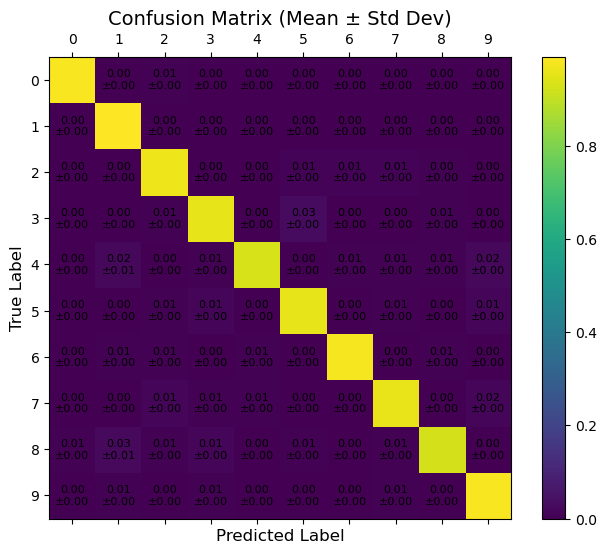

(10, 10, 20)

In [ ]:
def plot_confusion_matrix(mean_confusion_matrix, std_confusion_matrix, num_classes=10):
    # Plotting the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(mean_confusion_matrix, cmap='viridis')
    plt.colorbar(cax)

    for i in range(num_classes):
        for j in range(num_classes):
            if i != j:  
                text = f"{mean_confusion_matrix[i, j]:.2f}\n±{std_confusion_matrix[i, j]:.2f}"
                ax.text(j, i, text, ha='center', va='center', fontsize=8,
                        color='white' if mean_confusion_matrix[i, j] > 0.05 else 'black')

    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xticks(range(num_classes))
    ax.set_yticks(range(num_classes))
    ax.set_xticklabels(range(num_classes))
    ax.set_yticklabels(range(num_classes))
    plt.title('Confusion Matrix (Mean ± Std Dev)', fontsize=14)
    plt.show()
    

mean_confusion_matrix = np.mean(confusion_matrices, axis=2)
std_confusion_matrix = np.std(confusion_matrices, axis=2)
print(f"mean_confusion_matrix:\n{mean_confusion_matrix.round(3)}\n")
print(f"std_confusion_matrix:\n{std_confusion_matrix.round(3)}\n")

plot_confusion_matrix(mean_confusion_matrix, std_confusion_matrix)
confusion_matrices.shape



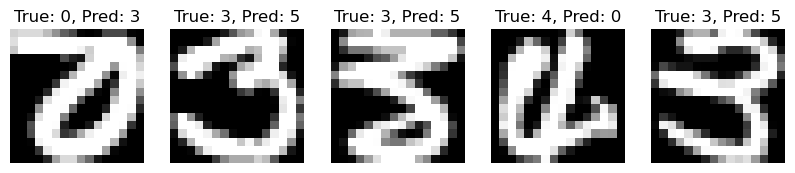

In [103]:
def visualize_hard_samples(hard_samples, run_idx=0):
    X_hard, y_true, y_pred = hard_samples[run_idx]
    num_samples = X_hard.shape[0]

    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(X_hard[i].reshape(16, 16), cmap='gray')  
        plt.title(f"True: {y_true[i]}, Pred: {y_pred[i]}")
        plt.axis('off')
    plt.show()

visualize_hard_samples(hard_samples)

In [104]:
num_runs = 20
cs = [0.1, 0.5, 1, 2, 5, 10]

In [105]:
train_errors_all, test_errors_all = basic_results(num_runs, cs, kernel_function=gaussian_kernel, mode='ovr')

[INFO] ---------- Run 1/20 ----------
      kernel parameter: 0.1
      [para=0.1] train_err=0.0003, test_err=0.0511
      kernel parameter: 0.5
      [para=0.5] train_err=0.0001, test_err=0.0645
      kernel parameter: 1
      [para=1] train_err=0.0000, test_err=0.0651
      kernel parameter: 2
      [para=2] train_err=0.0000, test_err=0.0661
      kernel parameter: 5
      [para=5] train_err=0.0000, test_err=0.0726
      kernel parameter: 10
      [para=10] train_err=0.0000, test_err=0.2059
[INFO] ---------- Run 2/20 ----------
      kernel parameter: 0.1
      [para=0.1] train_err=0.0013, test_err=0.0516
      kernel parameter: 0.5
      [para=0.5] train_err=0.0000, test_err=0.0527
      kernel parameter: 1
      [para=1] train_err=0.0000, test_err=0.0559
      kernel parameter: 2
      [para=2] train_err=0.0000, test_err=0.0618
      kernel parameter: 5
      [para=5] train_err=0.0000, test_err=0.0602
      kernel parameter: 10
      [para=10] train_err=0.0000, test_err=0.1978
[INF

In [ ]:
train_mean = train_errors_all.mean(axis=1)
train_std  = train_errors_all.std(axis=1)
test_mean  = test_errors_all.mean(axis=1)
test_std   = test_errors_all.std(axis=1)

print(" c |  Train Error(% mean±std)   |   Test Error(% mean±std)")
for i, c in enumerate(cs):
    print(f"{c} | {100*train_mean[i]:.6f}±{100*train_std[i]:.6f} | {100*test_mean[i]:.6f}±{100*test_std[i]:.6f}")

 c |  Train Error(% mean±std)   |   Test Error(% mean±std)
0.1 | 0.03±0.04 | 5.04±0.49
0.5 | 0.00±0.01 | 6.18±0.52
1 | 0.00±0.01 | 6.29±0.54
2 | 0.00±0.01 | 6.19±0.52
5 | 0.00±0.01 | 6.57±0.62
10 | 0.00±0.00 | 19.77±1.00


In [107]:
chosen_cs, train_errors, test_errors, confusion_matrices, hard_samples = cv_results(num_runs, cs, kernel_function=gaussian_kernel, mode='ovr')

[INFO] ---------- Run 1/20 ----------
      kernel parameter: 0.1
      [d=0.1] cv_error=0.0488
      kernel parameter: 0.5
      [d=0.5] cv_error=0.0604
      kernel parameter: 1
      [d=1] cv_error=0.0614
      kernel parameter: 2
      [d=2] cv_error=0.0614
      kernel parameter: 5
      [d=5] cv_error=0.0629
      kernel parameter: 10
      [d=10] cv_error=0.2131
Confusion Matrix for Run 1:
[[0.97269625 0.         0.00341297 0.01365188 0.         0.00341297
  0.00682594 0.         0.         0.        ]
 [0.         0.992      0.         0.         0.         0.
  0.004      0.004      0.         0.        ]
 [0.01005025 0.00502513 0.93969849 0.01005025 0.         0.01005025
  0.01005025 0.01507538 0.         0.        ]
 [0.00581395 0.         0.00581395 0.93023256 0.         0.05232558
  0.         0.         0.00581395 0.        ]
 [0.01666667 0.01666667 0.00555556 0.         0.88888889 0.01111111
  0.01111111 0.02222222 0.00555556 0.02222222]
 [0.0075188  0.         0.       

In [108]:
c_mean  = chosen_cs.mean()
c_std   = chosen_cs.std()
tr_mean = train_errors.mean()
tr_std  = train_errors.std()
te_mean = test_errors.mean()
te_std  = test_errors.std()

print(f"c* = {c_mean:.2f} ± {c_std:.2f}")
print(f"Train Error = {100*tr_mean:.2f}% ± {100*tr_std:.2f}%")
print(f"Test  Error = {100*te_mean:.2f}% ± {100*te_std:.2f}%")

c* = 0.10 ± 0.00
Train Error = 0.03% ± 0.01%
Test  Error = 4.66% ± 0.18%


In [116]:
num_runs = 20
ds = range(1, 8)

In [115]:
train_errors_all, test_errors_all = basic_results(num_runs, ds, kernel_function=polynomial_kernel, mode='ovo')

[INFO] ---------- Run 1/20 ----------
      kernel parameter: 1
      [para=1] train_err=0.0508, test_err=0.0828
      kernel parameter: 2
      [para=2] train_err=0.0089, test_err=0.0430
      kernel parameter: 3
      [para=3] train_err=0.0036, test_err=0.0387
      kernel parameter: 4
      [para=4] train_err=0.0008, test_err=0.0344
      kernel parameter: 5
      [para=5] train_err=0.0017, test_err=0.0328
      kernel parameter: 6
      [para=6] train_err=0.0009, test_err=0.0414
      kernel parameter: 7
      [para=7] train_err=0.0008, test_err=0.0306
[INFO] ---------- Run 2/20 ----------
      kernel parameter: 1
      [para=1] train_err=0.0512, test_err=0.0769
      kernel parameter: 2
      [para=2] train_err=0.0151, test_err=0.0435
      kernel parameter: 3
      [para=3] train_err=0.0032, test_err=0.0344
      kernel parameter: 4
      [para=4] train_err=0.0052, test_err=0.0376
      kernel parameter: 5
      [para=5] train_err=0.0011, test_err=0.0339
      kernel parameter: 

In [117]:
train_mean = train_errors_all.mean(axis=1)
train_std  = train_errors_all.std(axis=1)
test_mean  = test_errors_all.mean(axis=1)
test_std   = test_errors_all.std(axis=1)

print(" d |  Train Error(% mean±std)   |   Test Error(% mean±std)")
for i, d in enumerate(ds):
    print(f"{d:2d} | {100*train_mean[i]:.2f}±{100*train_std[i]:.2f} | {100*test_mean[i]:.2f}±{100*test_std[i]:.2f}")

 d |  Train Error(% mean±std)   |   Test Error(% mean±std)
 1 | 4.43±0.91 | 7.30±1.12
 2 | 1.56±1.97 | 4.79±1.83
 3 | 0.47±0.24 | 3.75±0.52
 4 | 0.28±0.12 | 3.47±0.54
 5 | 0.15±0.06 | 3.51±0.46
 6 | 0.11±0.05 | 3.64±0.39
 7 | 0.68±2.49 | 4.17±2.35


In [124]:
chosen_ds, train_errors, test_errors, confusion_matrices, hard_samples = cv_results(num_runs, ds, kernel_function=polynomial_kernel, mode='ovo')

[INFO] ---------- Run 1/20 ----------
      kernel parameter: 1
      [d=1] cv_error=0.0964
      kernel parameter: 2
      [d=2] cv_error=0.0516
      kernel parameter: 3
      [d=3] cv_error=0.0454
      kernel parameter: 4
      [d=4] cv_error=0.0379
      kernel parameter: 5
      [d=5] cv_error=0.0359
      kernel parameter: 6
      [d=6] cv_error=0.0362
      kernel parameter: 7
      [d=7] cv_error=0.0354
Confusion Matrix for Run 1:
[[0.98943662 0.         0.00352113 0.00352113 0.         0.
  0.00352113 0.         0.         0.        ]
 [0.         0.99612403 0.         0.         0.         0.
  0.00387597 0.         0.         0.        ]
 [0.0195122  0.         0.94634146 0.0097561  0.         0.0097561
  0.         0.0097561  0.00487805 0.        ]
 [0.         0.         0.00617284 0.97530864 0.         0.01234568
  0.         0.         0.00617284 0.        ]
 [0.         0.02339181 0.00584795 0.         0.94152047 0.00584795
  0.00584795 0.         0.         0.01754386

In [125]:
d_mean  = chosen_ds.mean()
d_std   = chosen_ds.std()
tr_mean = train_errors.mean()
tr_std  = train_errors.std()
te_mean = test_errors.mean()
te_std  = test_errors.std()

print(f"d* = {d_mean:.2f} ± {d_std:.2f}")
print(f"Train Error = {100*tr_mean:.2f}% ± {100*tr_std:.2f}%")
print(f"Test  Error = {100*te_mean:.2f}% ± {100*te_std:.2f}%")

d* = 7.00 ± 0.00
Train Error = 0.09% ± 0.00%
Test  Error = 3.44% ± 0.00%
